# Effective Graph Paper
Code to generate "Figure 1 - Effective Graph Example"

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
import numpy as np
import graphviz
import math
import cana
from cana.boolean_network import BooleanNetwork
from collections import defaultdict
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
from IPython.display import display, SVG
import networkx as nx

In [37]:
# Graph Example
logic = {
    0 : {'name':r'x1', 'in':[],     'out':[1] },
    1 : {'name':r'x2', 'in':[],     'out':[1] },
    2 : {'name':r'x3', 'in':[],     'out':[1] },
    3 : {'name':r'x4', 'in':[0,1,2],   'out':[0,0,0,0, 0,0,1,1]},
}
N = cana.boolean_network.BooleanNetwork(name='A', Nnodes=len(logic), logic=logic)
print(N)
# Attributes
att = defaultdict(dict)
# Position
cx, cy = 1,1
for i,deg in enumerate(np.linspace(0,360,4),start=0):
    r = 1.1
    deg += 135
    x, y = cx + r * math.cos(math.radians(deg)), cy + r * math.sin(math.radians(deg))
    att[i]['pos'] = "{:.2f},{:.2f}".format(x,y)
att[3]['pos'] = "{:.2f},{:.2f}".format(cx,cy)
# Color
att[0]['color'] = '#1f77b4'
att[1]['color'] = '#1f77b4'
att[2]['color'] = '#1f77b4'
att[3]['color'] = '#2ca02c'
#
SG = N.structural_graph()
EG = N.effective_graph(mode='input', bound='mean', threshold=-1)

# Compute TwoSymbols for Node 3
N.nodes[3]._check_compute_canalization_variables(two_symbols=True)
print(att)

<BNetwork(Name='A', N=4, Nodes=['x1', 'x2', 'x3', 'x4'])>
defaultdict(<class 'dict'>, {0: {'pos': '0.22,1.78', 'color': '#1f77b4'}, 1: {'pos': '0.72,-0.06', 'color': '#1f77b4'}, 2: {'pos': '2.06,1.28', 'color': '#1f77b4'}, 3: {'pos': '1.00,1.00', 'color': '#2ca02c'}})


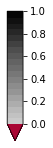

In [38]:
# ColorBar
interval = np.linspace(0.3, 1.0, 256)
colors = plt.cm.Greys(interval)
cmap = LinearSegmentedColormap.from_list('custom', colors)
cmap.set_under('#A90533')
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig = plt.figure(figsize=(2,2))
ax = fig.add_axes([0.1, 0.05, 0.11, 0.9])
bounds = [0,0.2,0.4,0.6,0.8,1]
boundaries = [-100] + np.linspace(0,1,20).tolist()

cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, boundaries=boundaries,
    extend='min', extendfrac=.15, ticks=bounds, spacing='uniform', orientation='vertical')


display(fig)
#plt.savefig('{path:s}/figure-example/colorbar.svg'.format(path=os.getcwd()),transparent=True)
plt.close()


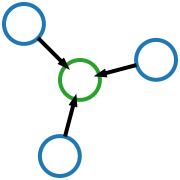

'SG.svg'

In [52]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='3,3', concentrate='false', simplify='false', overlap='false',splines='false',ratio='1')
pSG.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='12')
pSG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='4')

for nid, d in SG.nodes(data=True):
    label = ''#str(d['label'])
    pos = att[nid]['pos']
    color = att[nid]['color']
    fillcolor = 'white'
    pSG.node(str(nid), label=label, pos=pos, color=color, fillcolor=fillcolor)

for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    pSG.edge(uid, vid)
    
display(SVG(pSG.pipe(format='svg')),metadata={'isolated':True})
# Export
pSG._format = 'svg'
pSG.render("SG", cleanup=True)

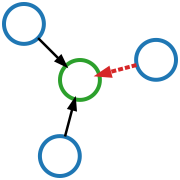

'EG.svg'

In [54]:
pEG = graphviz.Digraph(name='Effective Graph', engine='neato')
pEG.attr('graph', size='3,3', concentrate='false', simplify='false', overlap='false',splines='false', ratio='1')
pEG.attr('node', pin='true', shape='circle', fixedsize='true', width='.55', color='#00594c', style='filled', fillcolor='#515660', penwidth='4', fontname='Helvetica', fontcolor='black',fontsize='14')
pEG.attr('edge', arrowhead='normal', arrowsize='1', color='black', penwidth='4')

for nid, d in EG.nodes(data=True):
    label = ''#d['label']
    pos = att[nid]['pos']
    color = att[nid]['color']
    fillcolor = 'white'
    pEG.node(str(nid), label=label, pos=pos, color=color, fillcolor=fillcolor)

max_penwidth = 4
for uid, vid, d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '{:f}'.format(d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    label = ""#"{:.3f}".format(d['weight'])
    if d['weight'] > 0:
        rgb = cmap(d['weight'])
        hex = mpl.colors.rgb2hex(rgb)
        pEG.edge(uid, vid, label=label, weight=weight, penwidth=penwidth)
    else:
        pEG.edge(uid, vid, label=label, style='dashed', color='#d62728')
    
display(SVG(pEG.pipe(format='svg')), metadata={'isolated':True})
# Export
pEG._format = 'svg'
pEG.render("EG", cleanup=True)

In [48]:
def plot_look_up_table(nid, n):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    LUT = n.look_up_table().sort_index(ascending=False)
    # Count number of F in the LUT
    n_fs = LUT.shape[0]
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 120, 25, 25, 60, 25
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_fs*(cwidth+cyspace)-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + right)
    fheight = (bottom + ax1height + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='LUT')

    ### LUT Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for i,r in LUT.iterrows():
        ins = str(r['In:'])
        out = r['Out:']
        x = 0.
        xticks = []
        for input in ins:
            if input == '0':
                facecolor = 'white'
                textcolor = 'black'
            elif input == '1':
                facecolor = 'black'
                textcolor = 'white'      
            text = '%s'%(input)
            ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
            patches.append(r)
            xticks.append(x+cwidth/2)
            x += cwidth + cxspace

        x += sepcxspace
        r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
        ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*5, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
        ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
        patches.append(r)
        xticks.append(x+cwidth/2)
        yticks.append(y+cwidth/2)
        y += cwidth + cyspace

        #y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f_{%d}$"%(i+1) for i in range(n_fs)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputs + ['%s'%(n.name)], rotation=0, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    # FileName
    filename = n.name
    filename = filename.replace('/','_')
    filename = filename.replace(',','_')
    
    ## Display
    display(fig)
    
    ## Save to file
    plt.savefig('LUT-{nid:d}.svg'.format(nid=nid), dpi=dpi, transparent=True)
    plt.close()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


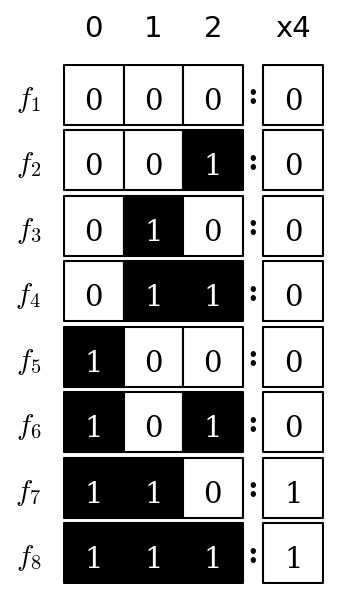

In [49]:
nid = 3
node = N.nodes[nid]
plot_look_up_table(nid,N.nodes[nid])

In [50]:
def plot_schemata(nid, n):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    pi0s,pi1s = n._prime_implicants
    ts0s,ts1s = n._two_symbols
    # Count number of PI and TS
    n_pi = sum(len(pis) for pis in [pi0s,pi1s])
    n_ts = sum(len(tss) for tss in [ts0s,ts1s])
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 160, 25, 25, 60, 90
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_pi*(cwidth+cyspace)+sepcyspace-cyspace)
    ax2width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax2height = (n_ts*(cwidth+cyspace)+sepcyspace-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + ax2width + right)
    fheight = (bottom + max(ax1height,ax2height) + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax2w = ((ax2width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _ax2h = ((ax2height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), facecolor='w', dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='PI')

    ### PI Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for out,pis in zip([1,0],[pi1s,pi0s]):
        for pi in pis:
            x = 0.
            xticks = []
            for input in pi:
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'            
                text = '%s'%(input) if (input!='2') else '#'
                ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
                patches.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
            ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            patches.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
        y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f^{'}_{%d}$"%(i+1) for i in range(n_pi)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputs + ['%s'%(n.name)], rotation=0, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border)
    ax1.set_ylim(-border,ax1height+border)


    # FileName
    filename = n.name.replace('/','_')
    filename = filename.replace(',','_')
    
    ## Display ##
    display(fig)
    
    ## Save to file
    plt.savefig('SCH-{nid:d}.svg'.format(nid=nid), dpi=dpi, transparent=True)
    plt.close()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.


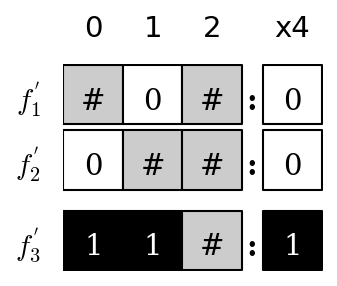

In [51]:
nid = 3
node = N.nodes[nid]
plot_schemata(nid, N.nodes[nid])